# 데이터

In [17]:
import pandas as pd
diabetes = pd.read_csv('../datasets/diabetes.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## 결측치 확인

In [7]:
diabetes.isna().sum(axis=0)

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## 이상치 확인
- 0이 될 수 없는 특정값을 확인

In [18]:
cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
(diabetes[cols] == 0).sum(axis=0)

Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

## 데이터 시각화

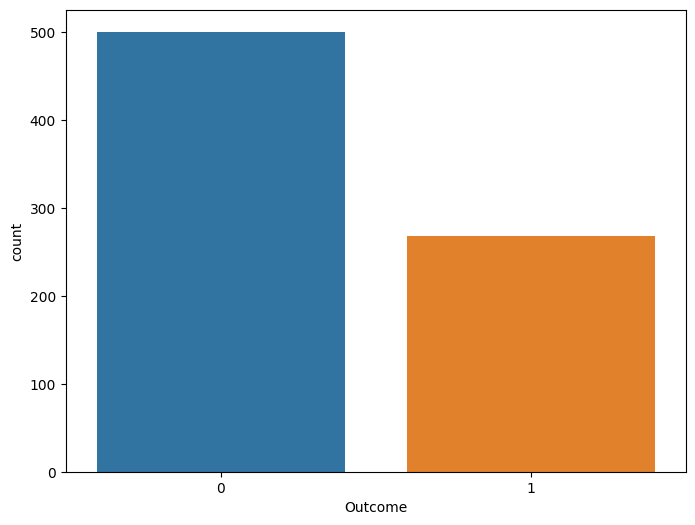

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.countplot(x='Outcome', data = diabetes)
plt.show()

# 당뇨병이 걸리지 않은 사람이 훨씬 많음을 확인 가능

### 범주별 데이터 수

In [12]:
diabetes['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

## 특성과 레이블 분리

In [20]:
X_data = diabetes.drop(['Outcome'], axis=1)
X_data.head()

y_data = diabetes['Outcome']
y_data.head()

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

## 테스트 데이터 분리

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data,y_data,
                                  test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(614, 8) (154, 8)
(614,) (154,)


## 이상치 처리

In [22]:
import numpy as np
def impute_zero(data, col):
    df = data.loc[data[col] != 0, col]
    avg = np.sum(df) / len(df)
    k = len(data.loc[ data[col] == 0, col])
    data.loc[ data[col] == 0, col ] = avg
    print('%s : fixed %d, mean: %.3f' % (col, k, avg))

    
for col in cols:
    impute_zero(X_train, col)

Glucose : fixed 5, mean: 121.847
BloodPressure : fixed 24, mean: 72.239
SkinThickness : fixed 176, mean: 28.596
Insulin : fixed 290, mean: 154.330
BMI : fixed 7, mean: 32.352


In [23]:
(X_train[cols] == 0).sum(axis=0)

# 다시 확인

Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64

In [24]:
for col in cols:
    impute_zero(X_test, col)

Glucose : fixed 0, mean: 121.052
BloodPressure : fixed 11, mean: 73.091
SkinThickness : fixed 51, mean: 31.524
Insulin : fixed 84, mean: 161.186
BMI : fixed 4, mean: 32.883


## 테스트 정규화

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

print(X_train_s[:5])

[[-5.26396861e-01 -1.25832567e+00  0.00000000e+00  4.22787785e-16
   0.00000000e+00  1.02533391e-15 -4.90734790e-01 -1.03594038e+00]
 [ 1.58804586e+00 -3.27397242e-01  8.07407436e-01 -5.46930179e-01
   0.00000000e+00 -5.99178052e-01  2.41502991e+00  1.48710085e+00]
 [-8.28460107e-01  5.70283740e-01 -2.17042447e+00 -1.14195109e+00
  -8.20791983e-01 -5.27026593e-01  5.49160552e-01 -9.48938958e-01]
 [-1.13052335e+00  1.30172750e+00 -1.83955426e+00  4.22787785e-16
   0.00000000e+00 -1.50828644e+00 -6.39291267e-01  2.79212217e+00]
 [ 6.81856121e-01  4.04046521e-01  6.41972330e-01  1.00012419e+00
   2.48169622e+00  1.99827450e+00 -6.86829340e-01  1.13909516e+00]]


### 넘파이 배열로 타입 변경

In [26]:
y_train = y_train.values
y_test = y_test.values
print(type(y_train), type(y_test))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


# 모델

- 이진 분류이므로 아웃풋 레이어에서 sigmoid 사용 가능

In [58]:
from tensorflow import keras
from tensorflow.keras import layers
def build_model():
    model = keras.Sequential()
    model.add(layers.Dense(12, input_dim=8, activation='relu'))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# activation=keras.layers.LeakyReLU(alpha=0.01)

In [59]:
model = build_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 12)                108       
                                                                 
 dense_18 (Dense)            (None, 8)                 104       
                                                                 
 dense_19 (Dense)            (None, 1)                 9         
                                                                 
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________


## 컴파일
- loss 함수 : binary crossentropy

In [60]:
model.compile(loss='binary_crossentropy',
        optimizer='adam',
        metrics=['acc'])

## 학습

In [95]:
EPOCHS = 500
BATCH_SIZE = 16
history = model.fit(X_train_s, y_train,
           epochs=EPOCHS,
           batch_size=BATCH_SIZE,
           validation_split = 0.2,
           verbose=1)

Epoch 1/500
31/31 [==============================] - 0s 3ms/step - loss: 0.3779 - acc: 0.8248 - val_loss: 0.4566 - val_acc: 0.7642
Epoch 2/500
31/31 [==============================] - 0s 2ms/step - loss: 0.3756 - acc: 0.8187 - val_loss: 0.4549 - val_acc: 0.7480
Epoch 3/500
31/31 [==============================] - 0s 2ms/step - loss: 0.3727 - acc: 0.8208 - val_loss: 0.4556 - val_acc: 0.7642
Epoch 4/500
31/31 [==============================] - 0s 2ms/step - loss: 0.3723 - acc: 0.8269 - val_loss: 0.4560 - val_acc: 0.7642
Epoch 5/500
31/31 [==============================] - 0s 2ms/step - loss: 0.3714 - acc: 0.8289 - val_loss: 0.4566 - val_acc: 0.7642
Epoch 6/500
31/31 [==============================] - 0s 2ms/step - loss: 0.3714 - acc: 0.8289 - val_loss: 0.4572 - val_acc: 0.7642
Epoch 7/500
31/31 [==============================] - 0s 2ms/step - loss: 0.3711 - acc: 0.8289 - val_loss: 0.4575 - val_acc: 0.7642
Epoch 8/500
31/31 [==============================] - 0s 2ms/step - loss: 0.3707 - a

31/31 [==============================] - 0s 2ms/step - loss: 0.3486 - acc: 0.8371 - val_loss: 0.4709 - val_acc: 0.7724
Epoch 64/500
31/31 [==============================] - 0s 2ms/step - loss: 0.3483 - acc: 0.8432 - val_loss: 0.4717 - val_acc: 0.7724
Epoch 65/500
31/31 [==============================] - 0s 2ms/step - loss: 0.3470 - acc: 0.8432 - val_loss: 0.4720 - val_acc: 0.7805
Epoch 66/500
31/31 [==============================] - 0s 2ms/step - loss: 0.3479 - acc: 0.8411 - val_loss: 0.4730 - val_acc: 0.7805
Epoch 67/500
31/31 [==============================] - 0s 2ms/step - loss: 0.3477 - acc: 0.8391 - val_loss: 0.4741 - val_acc: 0.7724
Epoch 68/500
31/31 [==============================] - 0s 2ms/step - loss: 0.3462 - acc: 0.8371 - val_loss: 0.4755 - val_acc: 0.7724
Epoch 69/500
31/31 [==============================] - 0s 2ms/step - loss: 0.3454 - acc: 0.8411 - val_loss: 0.4743 - val_acc: 0.7724
Epoch 70/500
31/31 [==============================] - 0s 2ms/step - loss: 0.3453 - acc: 0

Epoch 125/500
31/31 [==============================] - 0s 2ms/step - loss: 0.3194 - acc: 0.8574 - val_loss: 0.5264 - val_acc: 0.7642
Epoch 126/500
31/31 [==============================] - 0s 2ms/step - loss: 0.3181 - acc: 0.8595 - val_loss: 0.5264 - val_acc: 0.7642
Epoch 127/500
31/31 [==============================] - 0s 2ms/step - loss: 0.3182 - acc: 0.8595 - val_loss: 0.5264 - val_acc: 0.7642
Epoch 128/500
31/31 [==============================] - 0s 2ms/step - loss: 0.3179 - acc: 0.8635 - val_loss: 0.5273 - val_acc: 0.7642
Epoch 129/500
31/31 [==============================] - 0s 2ms/step - loss: 0.3179 - acc: 0.8513 - val_loss: 0.5288 - val_acc: 0.7480
Epoch 130/500
31/31 [==============================] - 0s 2ms/step - loss: 0.3174 - acc: 0.8574 - val_loss: 0.5313 - val_acc: 0.7642
Epoch 131/500
31/31 [==============================] - 0s 2ms/step - loss: 0.3152 - acc: 0.8574 - val_loss: 0.5305 - val_acc: 0.7561
Epoch 132/500
31/31 [==============================] - 0s 2ms/step - 

31/31 [==============================] - 0s 2ms/step - loss: 0.2949 - acc: 0.8656 - val_loss: 0.5903 - val_acc: 0.7561
Epoch 187/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2958 - acc: 0.8574 - val_loss: 0.5912 - val_acc: 0.7561
Epoch 188/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2946 - acc: 0.8656 - val_loss: 0.5928 - val_acc: 0.7642
Epoch 189/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2952 - acc: 0.8574 - val_loss: 0.5933 - val_acc: 0.7642
Epoch 190/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2936 - acc: 0.8656 - val_loss: 0.5966 - val_acc: 0.7561
Epoch 191/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2933 - acc: 0.8635 - val_loss: 0.5947 - val_acc: 0.7642
Epoch 192/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2938 - acc: 0.8656 - val_loss: 0.5965 - val_acc: 0.7561
Epoch 193/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2936 -

Epoch 248/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2760 - acc: 0.8859 - val_loss: 0.6537 - val_acc: 0.7398
Epoch 249/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2759 - acc: 0.8839 - val_loss: 0.6531 - val_acc: 0.7398
Epoch 250/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2758 - acc: 0.8839 - val_loss: 0.6564 - val_acc: 0.7398
Epoch 251/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2762 - acc: 0.8778 - val_loss: 0.6569 - val_acc: 0.7398
Epoch 252/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2763 - acc: 0.8880 - val_loss: 0.6613 - val_acc: 0.7398
Epoch 253/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2741 - acc: 0.8758 - val_loss: 0.6564 - val_acc: 0.7317
Epoch 254/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2747 - acc: 0.8839 - val_loss: 0.6581 - val_acc: 0.7398
Epoch 255/500
31/31 [==============================] - 0s 2ms/step - 

31/31 [==============================] - 0s 2ms/step - loss: 0.2564 - acc: 0.8941 - val_loss: 0.7277 - val_acc: 0.7480
Epoch 310/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2562 - acc: 0.8941 - val_loss: 0.7284 - val_acc: 0.7398
Epoch 311/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2572 - acc: 0.8941 - val_loss: 0.7300 - val_acc: 0.7398
Epoch 312/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2568 - acc: 0.8900 - val_loss: 0.7334 - val_acc: 0.7480
Epoch 313/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2570 - acc: 0.8941 - val_loss: 0.7331 - val_acc: 0.7480
Epoch 314/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2563 - acc: 0.9002 - val_loss: 0.7339 - val_acc: 0.7480
Epoch 315/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2553 - acc: 0.8921 - val_loss: 0.7328 - val_acc: 0.7480
Epoch 316/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2572 -

Epoch 371/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2403 - acc: 0.9043 - val_loss: 0.8074 - val_acc: 0.7480
Epoch 372/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2410 - acc: 0.9063 - val_loss: 0.8130 - val_acc: 0.7480
Epoch 373/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2398 - acc: 0.9063 - val_loss: 0.8197 - val_acc: 0.7398
Epoch 374/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2391 - acc: 0.9124 - val_loss: 0.8148 - val_acc: 0.7480
Epoch 375/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2384 - acc: 0.9063 - val_loss: 0.8150 - val_acc: 0.7480
Epoch 376/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2372 - acc: 0.9104 - val_loss: 0.8185 - val_acc: 0.7561
Epoch 377/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2370 - acc: 0.9084 - val_loss: 0.8177 - val_acc: 0.7561
Epoch 378/500
31/31 [==============================] - 0s 2ms/step - 

31/31 [==============================] - 0s 2ms/step - loss: 0.2218 - acc: 0.9165 - val_loss: 0.8760 - val_acc: 0.7398
Epoch 433/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2203 - acc: 0.9145 - val_loss: 0.8687 - val_acc: 0.7398
Epoch 434/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2203 - acc: 0.9165 - val_loss: 0.8741 - val_acc: 0.7398
Epoch 435/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2208 - acc: 0.9145 - val_loss: 0.8726 - val_acc: 0.7398
Epoch 436/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2201 - acc: 0.9145 - val_loss: 0.8822 - val_acc: 0.7398
Epoch 437/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2199 - acc: 0.9165 - val_loss: 0.8791 - val_acc: 0.7480
Epoch 438/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2206 - acc: 0.9165 - val_loss: 0.8819 - val_acc: 0.7398
Epoch 439/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2192 -

Epoch 494/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2067 - acc: 0.9165 - val_loss: 0.9301 - val_acc: 0.7398
Epoch 495/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2111 - acc: 0.9084 - val_loss: 0.9356 - val_acc: 0.7317
Epoch 496/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2053 - acc: 0.9165 - val_loss: 0.9305 - val_acc: 0.7317
Epoch 497/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2063 - acc: 0.9165 - val_loss: 0.9381 - val_acc: 0.7317
Epoch 498/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2050 - acc: 0.9165 - val_loss: 0.9396 - val_acc: 0.7317
Epoch 499/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2060 - acc: 0.9206 - val_loss: 0.9357 - val_acc: 0.7317
Epoch 500/500
31/31 [==============================] - 0s 2ms/step - loss: 0.2048 - acc: 0.9165 - val_loss: 0.9434 - val_acc: 0.7236


### 학습 곡선 그리기

In [32]:
import matplotlib.pyplot as plt
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Loss')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['acc'], label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_acc'], label = 'Val Accuracy')
    plt.legend()
    
    plt.show()

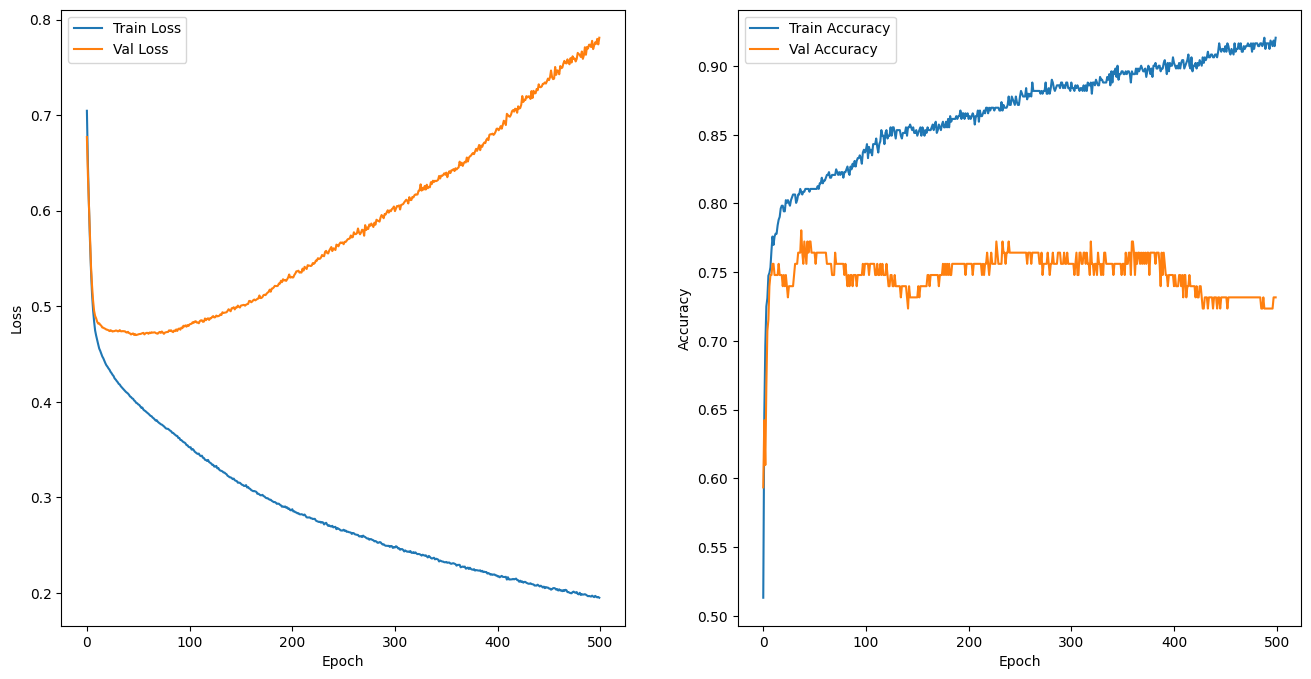

In [62]:
plot_history(history)

# ▶ 콜백 함수
- 학습이 진척이 없을 때 조기 종료(early stopping)하는 기능

## 모델 생성과 컴파일

In [63]:
from tensorflow import keras

model = build_model()
model.compile(loss='binary_crossentropy',
        optimizer='adam',
        metrics=['acc'])

## 학습-콜백기능
- 'val_loss' 를 기준으로, 학습 진척이 없을 때 종료

In [86]:
early_stop = keras.callbacks.EarlyStopping(
                                 monitor='val_loss', patience=10)

## 학습

In [93]:
EPOCHS = 500
BATCH_SIZE = 16
history = model.fit(X_train_s, y_train,
           epochs=EPOCHS,
           batch_size=BATCH_SIZE,
           validation_split = 0.2,
           callbacks=[early_stop],
           verbose=1)

Epoch 1/500
50/50 [==============================] - 0s 2ms/step - loss: 0.3824 - acc: 0.8228 - val_loss: 0.4517 - val_acc: 0.7642
Epoch 2/500
50/50 [==============================] - 0s 2ms/step - loss: 0.3825 - acc: 0.8248 - val_loss: 0.4562 - val_acc: 0.7561
Epoch 3/500
50/50 [==============================] - 0s 2ms/step - loss: 0.3813 - acc: 0.8289 - val_loss: 0.4549 - val_acc: 0.7642
Epoch 4/500
50/50 [==============================] - 0s 2ms/step - loss: 0.3808 - acc: 0.8269 - val_loss: 0.4547 - val_acc: 0.7724
Epoch 5/500
50/50 [==============================] - 0s 2ms/step - loss: 0.3796 - acc: 0.8269 - val_loss: 0.4534 - val_acc: 0.7561
Epoch 6/500
50/50 [==============================] - 0s 2ms/step - loss: 0.3784 - acc: 0.8187 - val_loss: 0.4533 - val_acc: 0.7561
Epoch 7/500
50/50 [==============================] - 0s 2ms/step - loss: 0.3777 - acc: 0.8167 - val_loss: 0.4544 - val_acc: 0.7724
Epoch 8/500
50/50 [==============================] - 0s 2ms/step - loss: 0.3788 - a

## 예측 & 결과 확인

In [91]:
y_pred = model.predict(X_test_s)

y_pred= (y_pred > 0.5).astype(np.int32).flatten()
y_pred

5/5 [==============================] - 0s 1ms/step


array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
      dtype=int32)

## 혼동 행렬 시각화

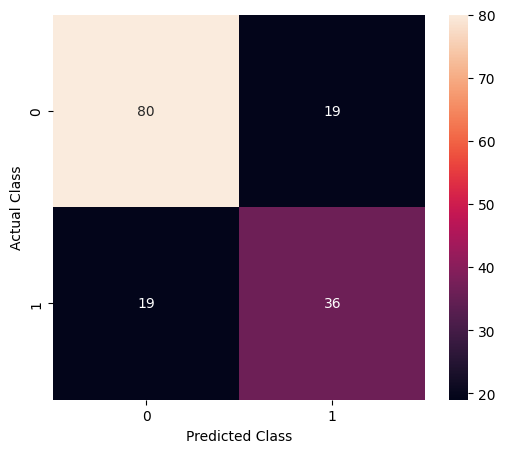

In [94]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cf_matrix, annot=True, cbar=True)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# FN 에 대한 위험도가 크기 때문에 해당 케이스를 최대한 줄여야함

## 평가 지표 계산, 출력

In [80]:
from sklearn.metrics import precision_score, recall_score, f1_score

def print_score(y_test, y_pred):
    print('precision: %.3f' % (precision_score(y_test, y_pred)))
    print('recall_score: %.3f' % (recall_score(y_test, y_pred)))
    print('f1_score: %.3f' % (f1_score(y_test, y_pred)))

In [85]:
from sklearn.metrics import classification_report

print_score(y_test, y_pred)

print(classification_report(y_test, y_pred))

precision: 0.655
recall_score: 0.655
f1_score: 0.655
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        99
           1       0.65      0.65      0.65        55

    accuracy                           0.75       154
   macro avg       0.73      0.73      0.73       154
weighted avg       0.75      0.75      0.75       154

